# Inverse Projection Transformation and Ray-Tracing for Generating Camera Rays

> see the Inverse Projection blog at [here](https://towardsdatascience.com/inverse-projection-transformation-c866ccedef1c)   
> see the Ray-tracing tutorial at [here](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-generating-camera-rays/generating-camera-rays)

In this article, we will take a tour and understand the mathematics and concepts of performing back-projection from 2D pixels coordinate to 3D points. I will then go through a simple example in Python to show the projection in action. [Code is adopted from here](https://github.com/darylclimb/cvml_project/tree/master/projections). We will assume that a depth map is provided to perform the 3D reconstruction. The concepts that we will go through are camera calibration parameters, projective transformation using intrinsic and its inverse, coordinate transformation between frames.

## 1. Central Projection of Pinhole Camera Model

<img src="../files/camera-projective-geometry.png" alt="drawing" width="700"/>

First and foremost, understanding the geometrical model of the camera projection serves as the core idea. What we are ultimately interested in is the depth, parameter $Z$. Here, we consider the simplest pinhole camera model with no skew or distortion factor.

3D points are mapped to the image plane $(u, v) = f(X, Y, Z)$. The complete mathematical model that describes this transformation can be written as $p = K[R|t] * P$.

$$
\lambda  \begin{pmatrix} u \\ v \\ 1 \end{pmatrix} = \begin{pmatrix}  
f_x & s & c_x \\
0 &f_y & c_y \\ 
0 & 0 &  1 \\ 
\end{pmatrix}
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_1  \\
r_{21} & r_{22} & r_{23} & t_2  \\
r_{31} & r_{32} & r_{33} & t_3
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

where:

- $(X, Y, Z)$ are the coordinates of a 3D point in the world coordinate space
- $(u, v)$ are the coordinates of the projection point in pixels
- $K$ is a camera matrix, or a matrix of intrinsic parameters
- $(c_x, c_y)$ is a principal point (the optical center) that is usually at the image center, in pixels.
- $f_x$, $f_y$ are the focal lengths expressed in \textbf{pixel units}. We have $f_x =F/p_x$ and $f_y =F/p_y$, where $F$ is the focal length in world units, typically expressed in millimeters, and $p_x$ and $p_y$ are the size of the pixel in world units.
- $s$ is pixel skew coefficient, which is non-zero if the image axes are not perpendicular, $s=f_x \tan{\alpha}$. In our example, we consider the simplest pinhole camera model with no skew or distortion factor, so we set $s=0$.

<img src="../files/calibration_skew.png" alt="drawing" width="100"/>

## 2. Backprojection

Suppose $(X, Y, Z, 1)$ is in the camera coordinate frame. Therefore, we do not need to consider the extrinsic matrix $[R|t]$, i.e. $[R|t] = [I | \mathbf{0}]$. 

<img src="../files/inverse-projection-1.jpg" alt="drawing" width="700"/>

The 3D points can be recovered with $Z$ given by the depth map and solving for $X$ and $Y$. We can then further transform the points back to the world frame if needed.

<img src="../files/inverse-projection-2.jpg" alt="drawing" width="700"/>

If we consider the pixel skew coefficient $s=0$, then the inverse intrinsic matrix is:

$$
K^{-1} = \begin{pmatrix}  
1/f_x &  & -c_x/f_x \\
0 &1/f_y & -c_y/f_y \\ 
0 & 0 &  1 \\ 
\end{pmatrix}
$$

Given the depth $Z$ () and $K^{-1}$, the corresponding backprojected 3D coordinate is obtained, 
$$
\begin{pmatrix} X \\ Y \\ Z \end{pmatrix} = K^{-1} \lambda \begin{pmatrix} u \\ v \\ 1 \end{pmatrix} = Z \begin{pmatrix}  
1/f_x & 0 & -c_x/f_x \\
0 &1/f_y & -c_y/f_y \\ 
0 & 0 &  1 \\ 
\end{pmatrix}
\begin{bmatrix}
u \\
v \\
1 \\
\end{bmatrix} = \begin{bmatrix}
Z(u - c_x)/f_x \\
Z(v - c_y)/f_y \\
Z \\
\end{bmatrix}
$$

## 3. Inverse projection example

Let's go through a simple example to digest the concepts. We will use the RGB and depth image as shown below. Pictures are acquired from a camera mounted on a car in a simulator, [CARLA](http://carla.org/). The depth map is stored as float32 and encodes up to a maximum of 1000m for depth values at infinity.

### 3.1 Intrinsic Parameters from Field of View (FoV)

- Instead of determining the intrinsic parameters using checkerboard, one can calculate the focal lengths and optical centre for the pinhole camera model. The information needed is the imaging sensor height and width in pixels and the effective `field of view` in the vertical and horizontal direction. 

- Camera manufacturer usually provides those. In our example, we will use $\pm 45$ degrees both in the vertical and horizontal direction. We will set the scale factor to 1.

- The focal lengths $(f_x, f_y)$ and the principal point $(c_x, x_y)$ can be determined using simple trigonometry. 

<img src="../files/fov-img.png" alt="drawing" width="400"/>

Now, we can compute the inverse as follows: 
- Step 1) Obtain the intrinsic camera parameters, K
- Step 2)Find the inverse of K
- Step 3)Apply equation above with Z as depth from a depth map. Which is implemented as

```python
# Using Linear Algebra
cam_coords = K_inv @ pixel_coords * depth.flatten()
```

A slower but more intuitive way of writing `Step 3)` is
```python
cam_points = np.zeros((img_h * img_w, 3))
i = 0
# Loop through each pixel in the image
for v in range(height):
    for u in range(width):
        # Apply equation above
        x = (u - u0) * depth[v, u] / fx
        y = (v - v0) * depth[v, u] / fy
        z = depth[v, u]
        cam_points[i] = (x, y, z)
        i += 1
```

### 3.2 Orthographic Projection: Top View (Optional)

With the points represented in 3D, one interesting application is to project it to a `top-down` view of the scene. This is usually a useful representation for mobile robots as the distances between obstacles are preserved. Furthermore, it is easy to interpret and utilize to perform path planning and navigation task. For this, we need to know the coordinate system in which the points references.

We will use the right-hand coordinate system as defined below

<img src="../files/camera-coordinate-pixel.png" alt="drawing" width="400"/>

For this simple example, which plane do you think the points should be projected?

<img src="../files/top-down-view.png" alt="drawing" width="200"/>

If your guess is on the plane y= 0, you are right as y represent height as defined by the camera coordinate system. We simply collapse the y component in the projection matrix. In this biry-eye view, you can easily measure the separation distances between all vehicles and objects.

### 3.3 Code

In [ ]:
def kitti_colormap(disparity, maxval=-1):
	"""
	A utility function to reproduce KITTI fake colormap
	Arguments:
	- disparity: numpy float32 array of dimension HxW
	- maxval: maximum disparity value for normalization (if equal to -1, 
              the maximum value in disparity will be used)
	
	Returns a numpy uint8 array of shape HxWx3.
	"""
	if maxval < 0:
		maxval = np.max(disparity)
                #print ('maxval = %f' % maxval)

	colormap = np.asarray([[0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174],
                           [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]])
	weights = np.asarray([8.771929824561404,5.405405405405405,8.771929824561404,
                          5.747126436781609,8.771929824561404,5.405405405405405,8.771929824561404,0])
	cumsum = np.asarray([0,0.114,0.299,0.413,0.587,0.701,0.8859999999999999,0.9999999999999999])

	colored_disp = np.zeros([disparity.shape[0], disparity.shape[1], 3])
	values = np.expand_dims(np.minimum(np.maximum(disparity/maxval, 0.), 1.), -1)
	bins = np.repeat(np.repeat(np.expand_dims(np.expand_dims(cumsum,axis=0),axis=0), disparity.shape[1], axis=1), 
                     disparity.shape[0], axis=0)
	diffs = np.where((np.repeat(values, 8, axis=-1) - bins) > 0, -1000, (np.repeat(values, 8, axis=-1) - bins))
	index = np.argmax(diffs, axis=-1)-1

	w = 1-(values[:,:,0]-cumsum[index])*np.asarray(weights)[index]


	colored_disp[:,:,2] = (w*colormap[index][:,:,0] + (1.-w)*colormap[index+1][:,:,0])
	colored_disp[:,:,1] = (w*colormap[index][:,:,1] + (1.-w)*colormap[index+1][:,:,1])
	colored_disp[:,:,0] = (w*colormap[index][:,:,2] + (1.-w)*colormap[index+1][:,:,2])

	return (colored_disp*np.expand_dims((disparity>0),-1)*255).astype(np.uint8)

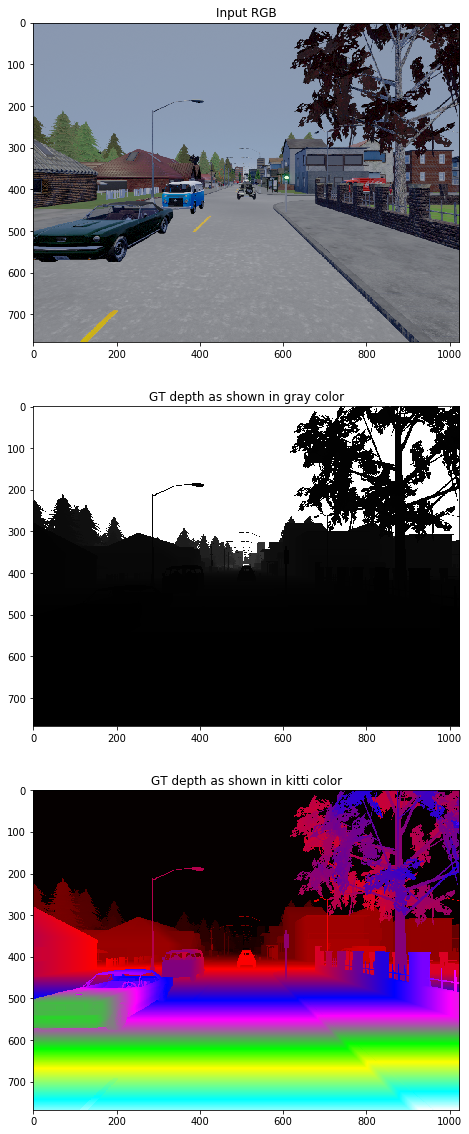

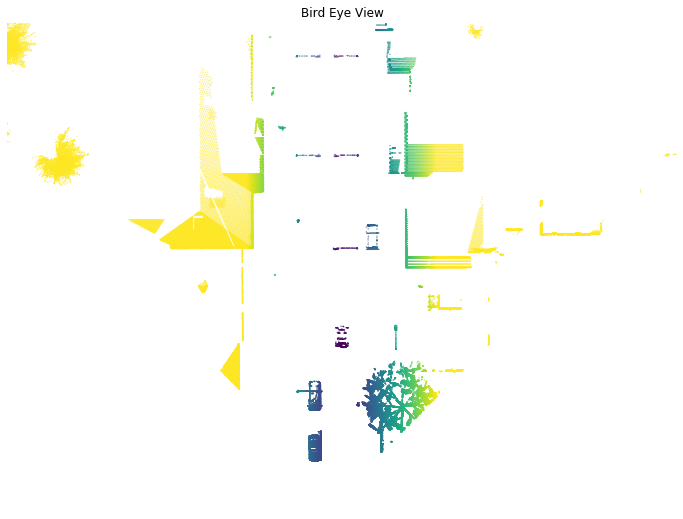

In [10]:
%matplotlib inline
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
#from geometry_utils import pixel_coord_np, intrinsic_from_fov

def pixel_coord_np(width, height):
    """
    Pixel in homogenous coordinate
    Returns:
        Pixel coordinate:       [3, width * height]
    """
    x = np.linspace(0, width - 1, width).astype(np.int)
    y = np.linspace(0, height - 1, height).astype(np.int)
    [x, y] = np.meshgrid(x, y)
    return np.vstack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))


def intrinsic_from_fov(height, width, fov=90):
    """
    Basic Pinhole Camera Model
    intrinsic params from fov and sensor width and height in pixels
    Returns:
        K:      [4, 4]
    """
    px, py = (width / 2, height / 2)
    hfov = fov / 360. * 2. * np.pi
    fx = width / (2. * np.tan(hfov / 2.))

    vfov = 2. * np.arctan(np.tan(hfov / 2) * height / width)
    fy = height / (2. * np.tan(vfov / 2.))

    return np.array([[fx, 0, px, 0.],
                     [0, fy, py, 0.],
                     [0, 0, 1., 0.],
                     [0., 0., 0., 1.]])


if __name__ == '__main__':
    # Load images
    rgb = cv2.imread('/home/ccj/mvs-depth/src/projections/inverse_projection/data/rgb.png')[:,:,::-1]

    # Depth is stored as float32 in meters
    depth = cv2.imread('/home/ccj/mvs-depth/src/projections/inverse_projection/data/depth.exr', cv2.IMREAD_ANYDEPTH)

    f, ax = plt.subplots(3, figsize=(10, 20))  
   
    ax[0].imshow(rgb)
    ax[0].set_title('Input RGB')
     
    depth[depth < 1e-3] = 1e-3
    ax[1].set_title('GT depth as shown in gray color')    
    ax[1].imshow(depth, cmap='gray')
    ax[2].imshow( kitti_colormap(1.0/depth)) # 1/depth to mimic the kitti color for disparity map; 
    ax[2].set_title('GT depth as shown in kitti color')

        
    # Get intrinsic parameters
    height, width, _ = rgb.shape
    K = intrinsic_from_fov(height, width, 90)  # +- 45 degrees
    K_inv = np.linalg.inv(K)

    # Get pixel coordinates
    pixel_coords = pixel_coord_np(width, height)  # [3, npoints]

    # Apply back-projection: K_inv @ pixels * depth
    cam_coords = K_inv[:3, :3] @ pixel_coords * depth.flatten()

    # back-projection using native for-loop.
    # Uncomment block to test this
    # cam_coords = np.zeros((height * width, 3))
    # u0 = K[0, 2]
    # v0 = K[1, 2]
    # fx = K[0, 0]
    # fy = K[1, 1]
    # i = 0
    # # Loop through each pixel in the image
    # for v in range(height):
    #     for u in range(width):
    #         # Apply equation in fig 3
    #         x = (u - u0) * depth[v, u] / fx
    #         y = (v - v0) * depth[v, u] / fy
    #         z = depth[v, u]
    #         cam_coords[i] = (x, y, z)
    #         i += 1
    # cam_coords = cam_coords.T


    # Limit points to 150m in the z-direction for visualisation
    cam_coords = cam_coords[:, np.where(cam_coords[2] <= 150)[0]]

    # Visualize
    pcd_cam = o3d.geometry.PointCloud()
    pcd_cam.points = o3d.utility.Vector3dVector(cam_coords.T[:, :3])
    # Flip it, otherwise the pointcloud will be upside down
    pcd_cam.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    o3d.visualization.draw_geometries([pcd_cam])

    def project_topview(cam_points):
        """
        Draw the topview projection
        """
        max_longitudinal = 70
        window_x = (-50, 50)
        window_y = (-3, max_longitudinal)

        x, y, z = cam_points
        # flip the y-axis to positive upwards
        y = - y

        # We sample points for points less than 70m ahead and above ground
        # Camera is mounted 1m above on an ego vehicle
        ind = np.where((z < max_longitudinal) & (y > -1.2))
        bird_eye = cam_points[:3, ind]

        # Color by radial distance
        dists = np.sqrt(np.sum(bird_eye[0:2:2, :] ** 2, axis=0))
        axes_limit = 10
        colors = np.minimum(1, dists / axes_limit / np.sqrt(2))

        # Draw Points
        fig, axes = plt.subplots(figsize=(12, 12))
        axes.scatter(bird_eye[0, :], bird_eye[2, :], c=colors, s=0.1)
        axes.set_xlim(window_x)
        axes.set_ylim(window_y)
        axes.set_title('Bird Eye View')
        plt.axis('off')

        plt.gca().set_aspect('equal')
        plt.show()

    # Do top view projection
    project_topview(cam_coords)

The Input RGB and the Depth are transformed back to 3D world

<img src="../files/RGB-Depth-3D-back-projected-points.png" alt="drawing" width="1200"/>

The 3D reconstructed point is shown in the following screenshot 

<img src="../files/3d-back-projected-points.png" alt="drawing" width="700"/>